# Synthetic light curves with Gaia sampling

Study of the Structure function, and how it can be used to derive a timescale 

## 1. Initialisation

Libraries and paths

In [1]:
# Libraries

import sys
import os

import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd

from   scipy.signal      import savgol_filter
from   itertools         import product
from   tqdm              import tqdm

sys.path.append('../../Benchmark_QM/Packages')
sys.path.append('../../GaiaDR3_study/Packages')


from   Handy             import get_files_paths
from   Handy             import amp_595

import SyntheticCurves   as     Sc
import StructureFunction as     SF

In [2]:
#Paths
path_init   = os.path.expanduser('~')
path        = get_files_paths(path_init + '/M2/Codes/GaiaDR3_study/paths.txt')
filepath    = path['synthetic_dr3']
path_obs_w  = path['dr3_obs_window']

## 2. Gaia sampling

- Get one light curve from the catalog
- Rapid study of the TimeG dispersion

In [4]:
# Get Gaia sampling

ID        = 761
band      = 'G'
path_star = path['gaia_data'] + f'/Nemesis_{ID}.csv'
star      = pd.read_csv(path_star, delimiter='\t')
times     = np.array(star[f'Time{band}'])
times     = times[~np.isnan(times)]

In [5]:
#time lags dispersion

perm = np.meshgrid(times, times)
perm = np.array(perm).transpose().reshape(len(perm[0])**2,2)

time_lag = []
for ti, tj in perm :
    time_lag.append(abs(ti-tj))
    
time_lag = np.array(time_lag)
time_lag = time_lag[~np.isnan(time_lag)]

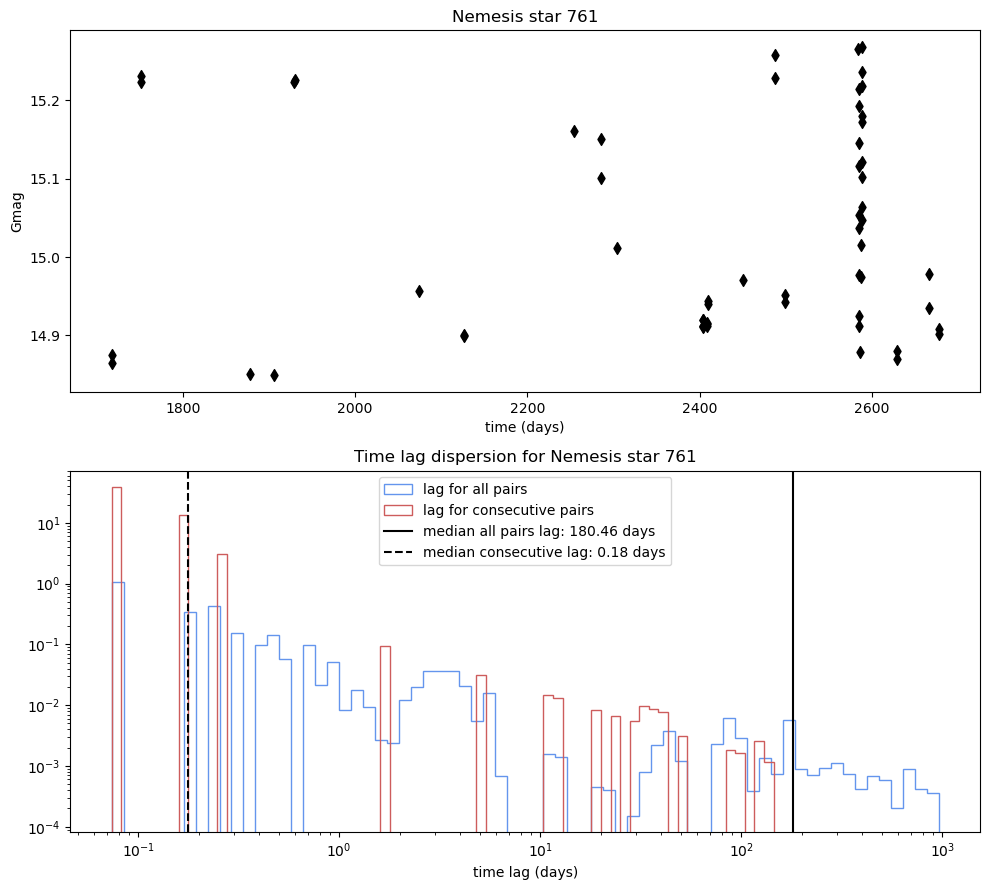

In [6]:
# Log-spaced bins
positive_time_lag = time_lag[time_lag > 0]
log_bins_time_lag = np.logspace(np.log10(min(positive_time_lag)),\
                                np.log10(max(positive_time_lag)), 70)
positive_diff_times = np.diff(times)[np.diff(times) > 0]
log_bins_diff_times = np.logspace(np.log10(min(positive_diff_times)),\
                                  np.log10(max(positive_diff_times)), 70)


# Plot
plt.figure(figsize=(10, 9), facecolor = 'white')

# First subplot (scatter plot)
plt.subplot(2, 1, 1)
plt.scatter(star['TimeG'], star['Gmag'], c='black', marker='d')
plt.xlabel('time (days)')
plt.ylabel('Gmag')
plt.title(f'Nemesis star {ID}')

# Second subplot (histograms)
plt.subplot(2, 1, 2)
plt.hist(time_lag, bins=log_bins_time_lag, density=True, histtype='step', color='cornflowerblue', label='lag for all pairs')
plt.hist(np.diff(times), bins=log_bins_diff_times, density=True, histtype='step', color='indianred', label='lag for consecutive pairs')

plt.axvline(np.median(time_lag), label=f'median all pairs lag: {np.round(np.median(time_lag), 2)} days', c='black')
plt.axvline(np.median(np.diff(times)), ls='--', label=f'median consecutive lag: {np.round(np.median(np.diff(times)), 2)} days', c='black')

plt.xlabel('time lag (days)')
plt.title(f'Time lag dispersion for Nemesis star {ID}')
plt.xscale('log')
plt.yscale('log')
plt.legend()


plt.tight_layout()
plt.show()


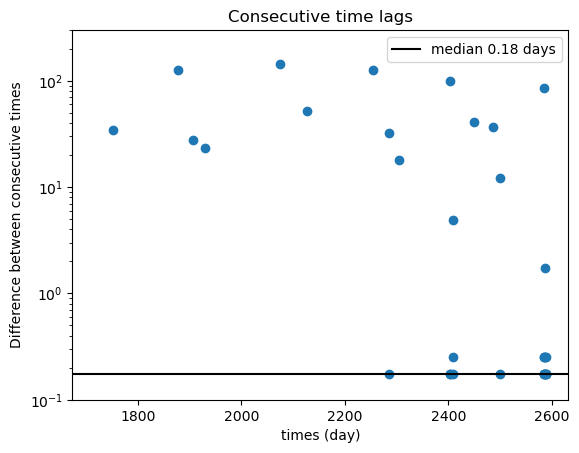

In [6]:
diff_times = np.diff(times)

plt.scatter(times[1:], diff_times)
plt.yscale('log')
plt.xlabel('times (day)')
plt.ylabel('Difference between consecutive times')
plt.title('Consecutive time lags')

plt.ylim(0.1, 300)
plt.axhline(np.median(diff_times), c = 'black', label = f'median {np.round(np.median(diff_times), 2)} days')
plt.legend()
plt.show()

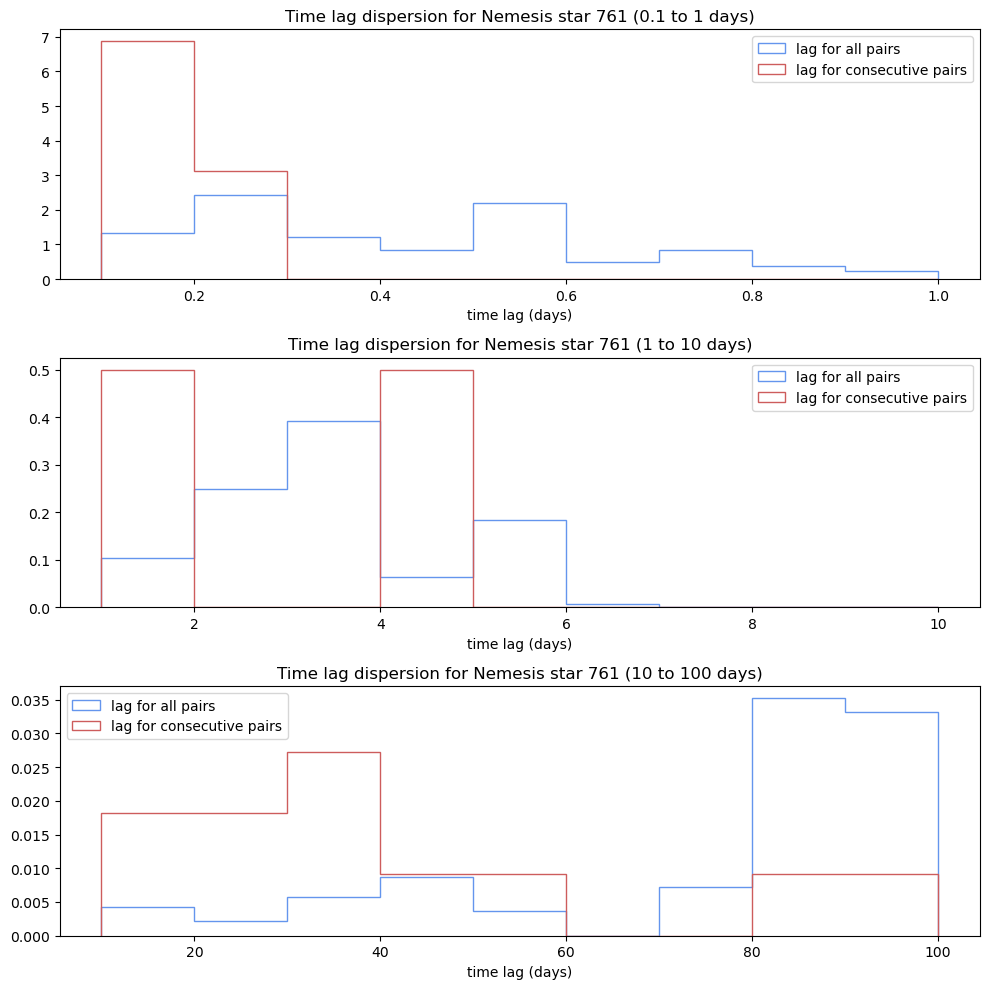

In [7]:
# Plot
plt.figure(figsize=(10, 10))

# time lags, 0.1 to 1 (0.1 steps)
plt.subplot(3, 1, 1)
linear_bins_01_to_1 = np.arange(0.1, 1.1, 0.1)
plt.hist(positive_time_lag, bins=linear_bins_01_to_1, density=True,\
         histtype='step', color='cornflowerblue', label='lag for all pairs')
plt.hist(np.diff(times), bins=linear_bins_01_to_1, density=True,\
         histtype='step', color='indianred', label='lag for consecutive pairs')
plt.xlabel('time lag (days)')
plt.title(f'Time lag dispersion for Nemesis star {ID} (0.1 to 1 days)')
plt.legend()

# time lags, 1 to 10 (1 day steps)
plt.subplot(3, 1, 2)
linear_bins_1_to_10 = np.arange(1, 11, 1)
plt.hist(positive_time_lag, bins=linear_bins_1_to_10, density=True,\
         histtype='step', color='cornflowerblue', label='lag for all pairs')
plt.hist(np.diff(times), bins=linear_bins_1_to_10, density=True,\
         histtype='step', color='indianred', label='lag for consecutive pairs')
plt.xlabel('time lag (days)')
plt.title(f'Time lag dispersion for Nemesis star {ID} (1 to 10 days)')
plt.legend()

# time lags, 10 to 100 (10 days steps)
plt.subplot(3, 1, 3)
linear_bins_10_to_100 = np.arange(10, 101, 10)
plt.hist(positive_time_lag, bins=linear_bins_10_to_100, density=True,\
         histtype='step', color='cornflowerblue', label='lag for all pairs')
plt.hist(np.diff(times), bins=linear_bins_10_to_100, density=True,\
         histtype='step', color='indianred', label='lag for consecutive pairs')
plt.xlabel('time lag (days)')
plt.title(f'Time lag dispersion for Nemesis star {ID} (10 to 100 days)')
plt.legend()

plt.tight_layout()
plt.show()


## 3. Make synthetic data

2 periodic light curves are made (sine function, without noise) : 
- 1 with gaia sampling
- 1 with 1 observation per night (evenly-spaced)

In [8]:
#Parameters
period   = 9    #days
amp      = 0.7  #mag
med_mag  = 12   #mag

#Gaia sampling
mag      = med_mag + amp/2 * np.sin(2 * np.pi * (times - min(times))/period) + np.random.normal(0, 0.02, len(times))

#1 obs/night
t_even   = np.arange(min(times), max(times), 1)
mag_even = med_mag + amp/2 * np.sin(2 * np.pi * (t_even - min(t_even))/period)

## 4. compute the Structure Function
I used Eq.2 from Sergison+2019 to compute the structure function :

\begin{equation}
SF(\tau_1, \tau_2) = \frac{1}{p(\tau_1, \tau_2)} \sum{\frac{(mag_i - mag_j)^2}{mag_{med}^2}}
\end{equation}

In [19]:
'''
This package computes the Structure function as implemented by Sergison+19 and Venuti+21, in order to apply it to GaiaDR3 data
'''

#################################
#Libraries

import numpy             as     np
import pandas            as     pd
from   scipy.signal      import savgol_filter


def structure_function_slow(mag, time, num_bins = 100, epsilon = 1) :
    """
    Calculate the structure function of a magnitude time series using a slow method.

    Parameters:
    - mag, time (numpy.ndarray): magnitudes and times of the light curve
    - interp : if False, no interpolation is made and a discrete SF is returned
    - num_bins : number of bins for time_bins
    - epsilon : tolerence threshold

    Returns:
    - sf (numpy.ndarray): The calculated structure function
    - time_bins (numpy.ndarray): corresponding log-spaced time bins.
    """
    
    tmin, tmax = min(np.diff(time)), max(time)-min(time)
    
    # Create logarithmically spaced time bins
    time_bins = np.logspace(np.log10(tmin), np.log10(tmax), num=num_bins, endpoint=True, base=10.0) #check


    sf       = np.zeros(len(time_bins)-1)
    time_lag = np.zeros(len(time_bins)-1)

    #Compute all time lags, corresponding delta_mags
    delta_t_  = []
    delta_mag = []
    
    for i in range(len(time)):
        for j in range(i+1, len(time)):
            dt = abs(time[i] - time[j])
            delta_t_.append(dt)
            delta_mag.append((mag[i] - mag[j])**2)
            
    delta_t_  = np.array(delta_t_)
    delta_mag = np.array(delta_mag)
    
    it_list = []
    for i in (range(len(time_bins)-1)):
        it = 0
        for j, tau in enumerate(delta_t_ ):
            if ((time_bins[i]<tau) & (time_bins[i+1]>tau)) :
                           
                sf[i] += delta_mag[j] #/np.median(mag)**2
                it    += 1
    
        if it != 0 :
            sf[i] = sf[i]/it    
            it_list.append(it)

        else :
            sf[i] = np.nan 
            it_list.append(it)
            
        time_lag[i] = np.mean([time_bins[i+1],time_bins[i]])
    
    #Remove nan
    sel                     = ~np.isnan(sf)
    sf_sel, time_lag_sel   = sf[sel], time_lag[sel]
    it_list                 = np.array(it_list)[sel]
    
    return sf_sel, time_lag_sel, np.array(it_list)
    
def find_timescale(sf, tau):
    """
    Find the timescale corresponding to the first peak or plateau in the structure function.

    Parameters:
    - sf, tau (numpy.ndarray): The Structure function.

    Returns:
    - timescale (int): The timescale corresponding to the first peak or plateau.
    """
    
    slope     = np.gradient(sf)
    signs     = np.sign(slope)
    
    peaks = []
    for i, sign in enumerate(signs) :  #find a better way to compute this
        if i>=2 :
            if (sign == -1 or sign == 0) and signs[i-1] == 1:# and signs[i-2] == 1 :
                peaks.append(i)
                
    tau_high = np.array(tau)[peaks]   
    ind_tau  = np.where(tau_high > 0.7)[0][0]

    return tau_high[ind_tau]


In [20]:
#Structure function for light curve with gaia sampling

sf, t_log, it        = structure_function_slow(np.array(mag), np.array(times-min(times)),\
                                               num_bins = 50)
ts                   = find_timescale(sf, t_log)

In [22]:
#Structure function for light curve with 1obs/night
compute = input('run this cell ?')

if compute in ['y', 'Y', 'yes']:
    sf_even, t_log_even, it_even = structure_function_slow(np.array(mag_even),\
                                   np.array(t_even-min(t_even)),\
                                   num_bins = len(t_even))
ts_even                          = find_timescale(sf_even, t_log_even)

run this cell ?y


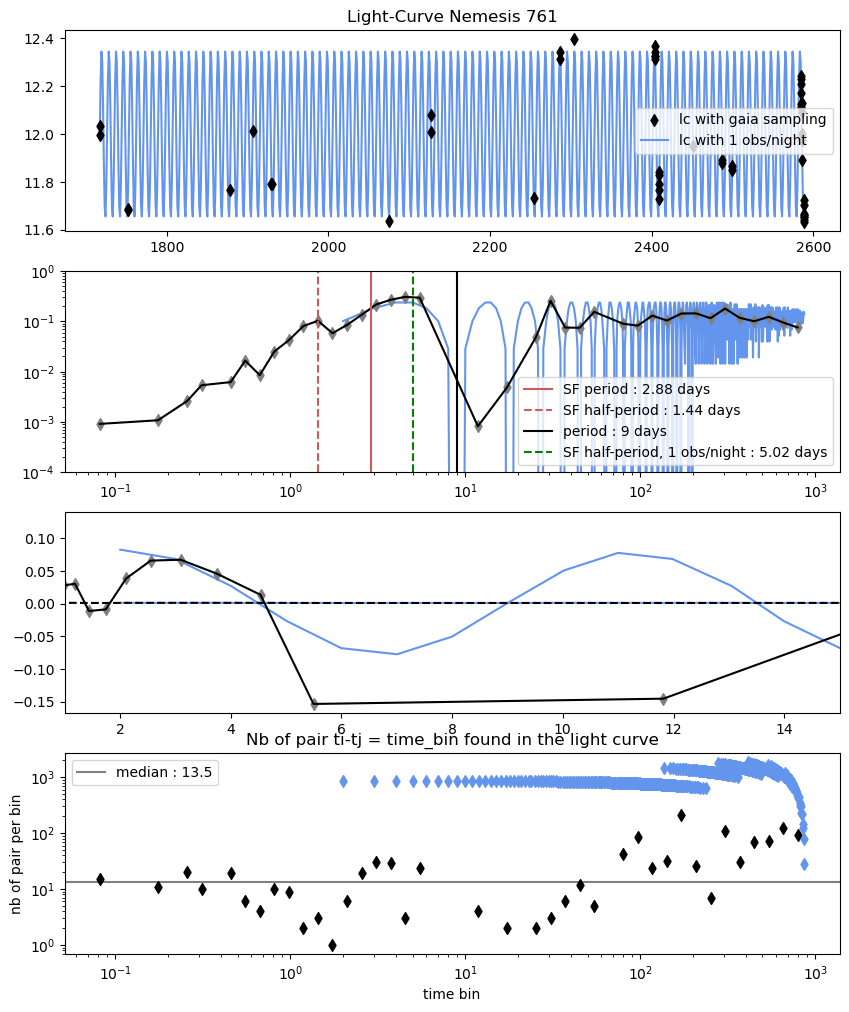

In [23]:
fig, ax = plt.subplots(4, 1, figsize = (10, 12))
ax1     = ax[0]
ax2     = ax[1]
ax2b    = ax[2]
ax3     = ax[3]

# Light curve
ax1.scatter(times, mag, c = 'black', marker = 'd', label = 'lc with gaia sampling')
ax1.set_title(f'Light-Curve Nemesis {ID}')
ax1.plot(t_even, mag_even, c = 'cornflowerblue', zorder = 0, label = 'lc with 1 obs/night')
ax1.legend()

# SF
ax2.scatter(t_log, sf, c = 'grey', marker = 'd')
ax2.plot(t_log, sf, c = 'black')
ax2.plot(t_log_even, sf_even, c = 'cornflowerblue', zorder = 0) 
ax2.axvline(2*ts, c = 'indianred',\
            label = f'SF period : {np.round(2*ts, decimals = 2)} days')
ax2.axvline(ts, c = 'indianred',\
            label = f'SF half-period : {np.round(ts, decimals = 2)} days', ls = '--')
ax2.axvline(period, label = f'period : {period} days', c = 'black')
ax2.axvline(ts_even, label = f'SF half-period, 1 obs/night : {np.round(ts_even, 2)} days', c = 'green', ls = '--')
ax2.legend()
#ax2.set_xlim(1, 15)
ax2.set_ylim(10e-5, 10e-1)
ax2.set_xscale('log')
ax2.set_yscale('log')

#gradient
ax2b.scatter(t_log, np.gradient(sf),c = 'grey', marker = 'd')
ax2b.plot(t_log, np.gradient(sf), c = 'black')
ax2b.plot(t_log_even, np.gradient(sf_even), c = 'cornflowerblue', zorder = 0)

ax2b.plot(t_log, 1e-3 + 1e-4*np.sign(np.gradient(sf)), c = 'black', ls = '--')
ax2b.plot(t_log_even, 1e-3 + 1e-4*np.sign(np.gradient(sf_even)), c = 'cornflowerblue', ls = '--', zorder = 0)

ax2b.set_xlim(1, 15)

#Nb of pairs found for each
ax3.scatter(t_log, it, c = 'black', marker = 'd')
ax3.scatter(t_log_even, it_even, c = 'cornflowerblue', marker = 'd')
ax3.set_xlabel('time bin')
ax3.set_ylabel('nb of pair per bin')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_title('Nb of pair ti-tj = time_bin found in the light curve')
ax3.axhline(np.median(it), c = 'grey', zorder = 0, label = f'median : {np.round(np.median(it), 2)}')
ax3.legend()


plt.show()

## Bonus : time lags dispersion for the evenly-spaced time series

In [33]:
#time lags dispersion

perm = np.meshgrid(t_even, t_even)
perm = np.array(perm).transpose().reshape(len(perm[0])**2,2)

time_lag_even = []
for ti, tj in perm :
    time_lag_even.append(abs(ti-tj))
    
time_lag_even = np.array(time_lag_even)
time_lag_even = time_lag_even[~np.isnan(time_lag_even)]

# Filter out non-positive values before creating logarithmically spaced bins
positive_time_lag = time_lag_even[time_lag_even > 0]
log_bins_time_lag = np.logspace(np.log10(min(positive_time_lag)), np.log10(max(positive_time_lag)), 70)
positive_diff_times = np.diff(t_even)[np.diff(t_even) > 0]
log_bins_diff_times = np.logspace(np.log10(min(positive_diff_times)), np.log10(max(positive_diff_times)), 70)



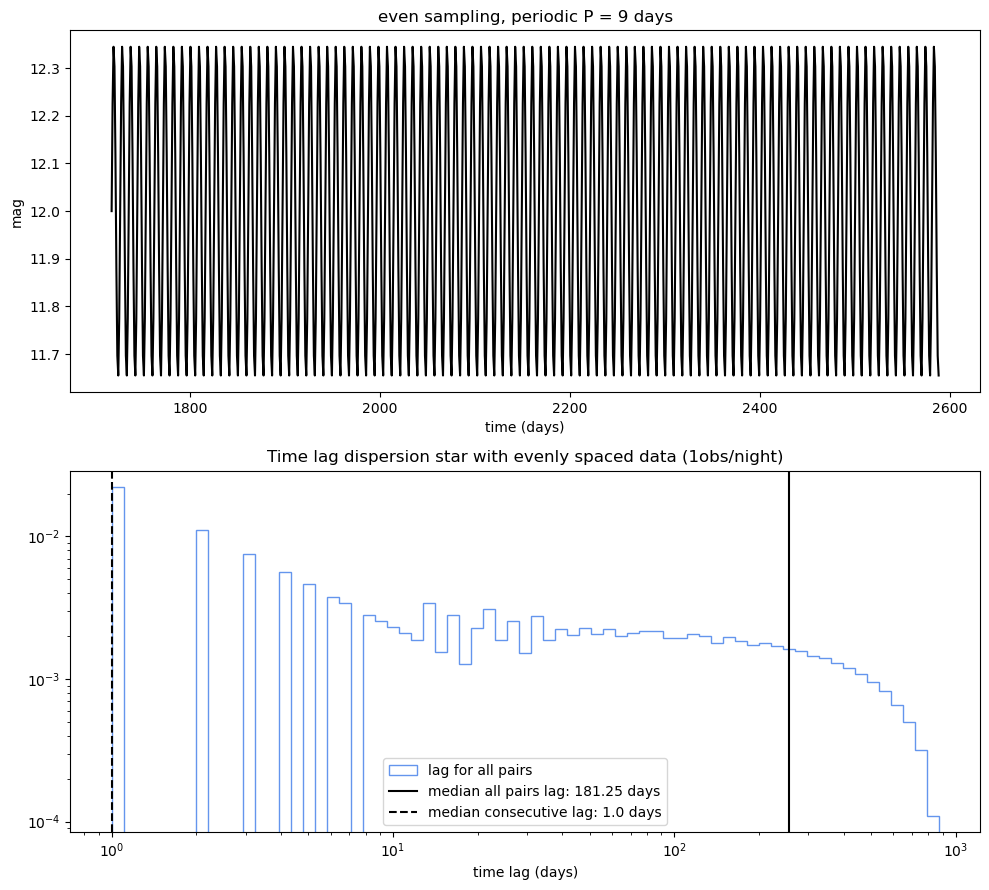

In [16]:

# Plot
plt.figure(figsize=(10, 9), facecolor = 'white')

# First subplot (scatter plot)
plt.subplot(2, 1, 1)
plt.plot(t_even, mag_even, c='black')
plt.xlabel('time (days)')
plt.ylabel('mag')
plt.title(f'even sampling, periodic P = {period} days')

# Second subplot (histograms)
plt.subplot(2, 1, 2)
plt.hist(time_lag_even, bins=log_bins_time_lag, density=True, histtype='step', color='cornflowerblue', label='lag for all pairs')

plt.axvline(np.median(time_lag_even), label=f'median all pairs lag: {np.round(np.median(time_lag), 2)} days', c='black')
plt.axvline(np.median(np.diff(t_even)), ls='--', label=f'median consecutive lag: {np.round(np.median(np.diff(t_even)), 2)} days', c='black')

plt.xlabel('time lag (days)')
plt.title(f'Time lag dispersion star with evenly spaced data (1obs/night)')
plt.xscale('log')
plt.yscale('log')
plt.legend()


plt.tight_layout()
plt.show()


## SF for Gaia observational windows

In [17]:
#Observational window

dr        = 'DR3'
path_star = path_obs_w + f'/gaia_{dr}.csv'
star      = pd.read_csv(path_star, delimiter=',')
t_obs     = np.array(star[f'jd_norm'])
t_obs     = t_obs[~np.isnan(t_obs)]

#mags
mag_obs   = med_mag + amp/2 * np.sin(2 * np.pi * (t_obs - min(t_obs))/period)

In [18]:
#Structure function for light curve with gaia sampling

sf_obs, t_log_obs, it_obs = structure_function_slow(np.array(mag_obs), np.array(t_obs-min(t_obs)),\
                                                  interp = False, num_bins = len(t_obs))
ts_obs                    = find_timescale(sf_obs, t_log_obs)

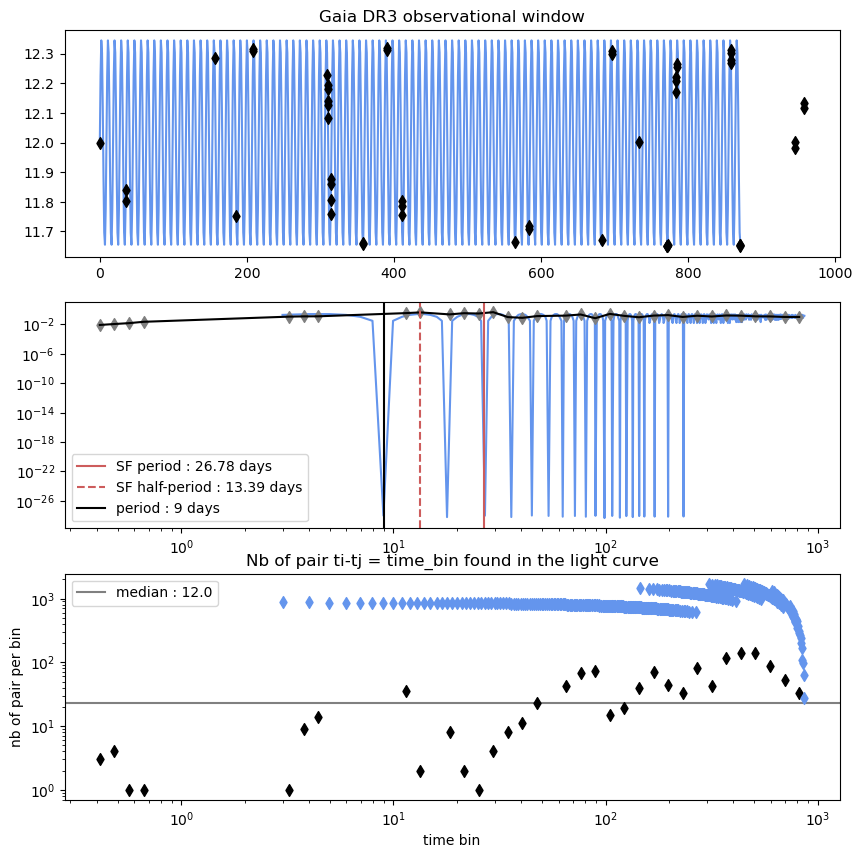

In [19]:
fig, ax = plt.subplots(3, 1, figsize = (10, 10))
ax1     = ax[0]
ax2     = ax[1]
ax3     = ax[2]

# Light curve
ax1.scatter(t_obs, mag_obs, c = 'black', marker = 'd')
ax1.set_title(f'Gaia DR3 observational window')
ax1.plot(t_even-min(t_even), mag_even, c = 'cornflowerblue', zorder = 0)

# SF
ax2.scatter(t_log_obs, sf_obs, c = 'grey', marker = 'd')
ax2.plot(t_log_obs, sf_obs, c = 'black')
ax2.plot(t_log_even, sf_even, c = 'cornflowerblue', zorder = 0) 
ax2.axvline(2*ts_obs, c = 'indianred',\
            label = f'SF period : {np.round(2*ts_obs, decimals = 2)} days')
ax2.axvline(ts_obs, c = 'indianred',\
            label = f'SF half-period : {np.round(ts_obs, decimals = 2)} days', ls = '--')
ax2.axvline(period, label = f'period : {period} days', c = 'black')
ax2.legend()
ax2.set_xscale('log')
ax2.set_yscale('log')

#Nb of pairs found for each
ax3.scatter(t_log_obs, it_obs, c = 'black', marker = 'd')
ax3.scatter(t_log_even, it_even, c = 'cornflowerblue', marker = 'd')
ax3.set_xlabel('time bin')
ax3.set_ylabel('nb of pair per bin')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_title('Nb of pair ti-tj = time_bin found in the light curve')
ax3.axhline(np.median(it_obs), c = 'grey', zorder = 0, label = f'median : {np.round(np.median(it), 2)}')
ax3.legend()


plt.show()

In [37]:
mag_noise =  np.random.normal(0, 0.02, len(times))

In [38]:
#Structure function for light curve with gaia sampling

sf_noise, t_log_noise, it_noise        = structure_function_slow(np.array(mag_noise), np.array(times-min(times)),\
                                               interp = False, num_bins = 100)
ts_noise                  = find_timescale(sf_noise, t_log_noise)

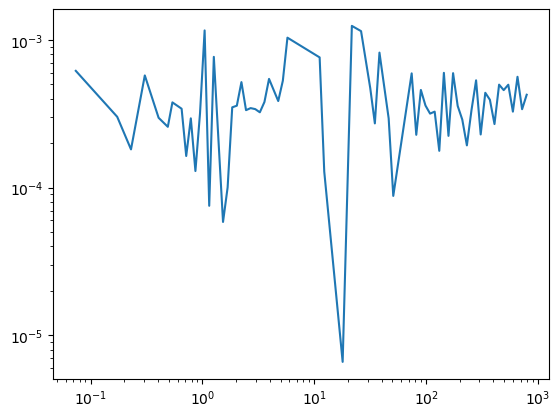

In [41]:
plt.loglog(t_log_noise,sf_noise)

In [55]:
#Parameters
periods  = [2, 10, 25]    #days
amps      = [0.7, 0.7, 0.7]  #mag
med_mags  = [10, 10, 10]   #mag

#Gaia sampling
lc = pd.DataFrame({'times' : times})
for i, period in enumerate(periods) :
    lc[f'mag_{period}'] = med_mags[i] + amps[i]/2 * np.sin(2 * np.pi * (times - min(times))/period) + np.random.normal(0, 0.02, len(times))

lc

,times,mag_2,mag_10,mag_25
0,1717.102578,10.002094,10.016904,9.998312
1,1717.176592,10.041838,10.016206,10.008681
2,1751.490585,10.288140,10.146552,10.248160
3,1751.564598,10.340064,10.133236,10.267554
4,1878.077661,10.042473,10.224028,10.157351
5,1906.064287,10.051723,9.781734,9.869664
6,1929.484625,10.350848,10.360485,10.005431
7,1929.558626,10.371984,10.341231,9.996607
8,2074.620778,9.642304,9.634908,10.327470
9,2126.289066,9.805908,9.816593,10.247029


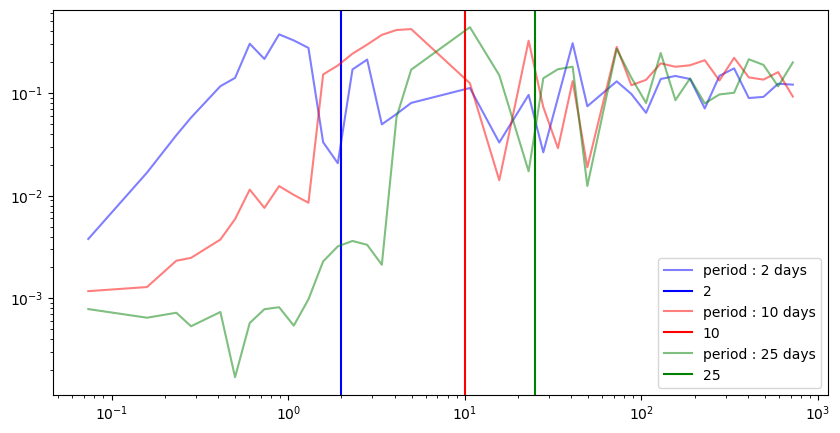

In [56]:
#Structure function for light curve with gaia sampling
colors = ['blue', 'red', 'green']
plt.figure(figsize = (10, 5))
for i, period in enumerate(periods) :
    sf_tmp, t_log_tmp, it_tmp        = structure_function_slow(np.array(lc[f'mag_{period}']), np.array(times-min(times)),\
                                                   interp = False, num_bins = 50)
    ts_tmp                = find_timescale(sf_tmp, t_log_tmp)
    plt.loglog(t_log_tmp, sf_tmp, label = f'period : {period} days', c = colors[i], alpha = .5)
    plt.axvline(period, label = f'{period}', c = colors[i])
plt.legend()